In [2]:
import keras

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# PCA Demo

You may be familiar with Principal Components Analysis, perhaps the most common technique for dimensionality reduction.

PCA uses [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular-value_decomposition) to find a new basis for a dataset. The new transformed features are uncorrelated and the basis vectors maximize the variance along the first dimension, then the remaining variance along the second, and so forth.

PCA can be used as a lossy compression. We can take observations, find a PCA transformation, and then use that transformation to encode and then decode the observations in the dataset. This process of taking an observation (often a single image), encoding it into an internal representation, and then decoding it into a "prediction" of a similar form to the input is called **autoencoding**. While this is typically the purpose behind using PCA, PCA does provide a familiar starting point for autoencoders.

Autoencoders are useful when we are interested in this internal representation (e.g. for transfer learning) or when we wish to process our observations (such as for image denoising, super-resolution, or image-image learning). 

First, let's look at an Keras autoencoder that re-implements PCA. We can do this by using a single linear layer to encode images into our components and then a second linear layer to decode the components. When we minimize a MSE loss, the solution to this is PCA ([see this lecture for more details](https://www.cs.toronto.edu/~urtasun/courses/CSC411/14_pca.pdf)).  

In [90]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1,28*28).astype("float64")/255
x_test = x_test.reshape(-1,28*28).astype("float64")/255

In [91]:
n_components = 100

In [92]:
from sklearn import decomposition

mnist_pca = decomposition.PCA(n_components=n_components, svd_solver="full")
mnist_pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [93]:
encoded_imgs = mnist_pca.transform(x_test)
decoded_imgs = mnist_pca.inverse_transform(encoded_imgs)

print(f"""
original shape: {x_test.shape},
encoded shape: {encoded_imgs.shape},
dencoded shape: {decoded_imgs.shape},
""")


original shape: (10000, 784),
encoded shape: (10000, 100),
dencoded shape: (10000, 784),



<Figure size 1440x288 with 0 Axes>

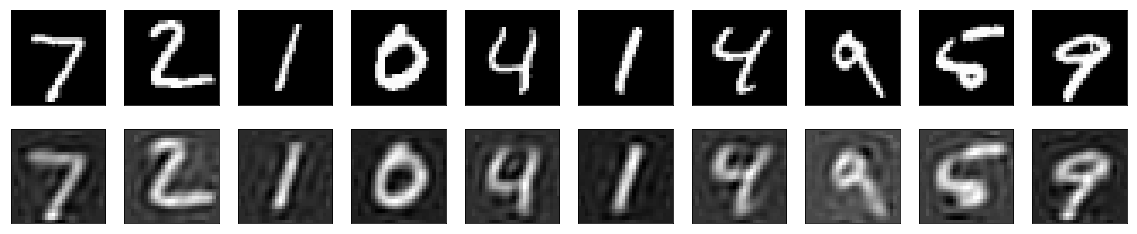

In [94]:
n = 10
plt.figure(figsize=(20, 4))

fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(20,4))
for i in range(n):
    # display original
    ax = axes[0,i]
    ax.imshow(x_test[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = axes[1,i]
    ax.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [95]:
# this is our input placeholder
input_img = keras.layers.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = keras.layers.Dense(n_components, use_bias=False, name="encoder")(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = keras.layers.Dense(784, use_bias=False, name="dencoder")(encoded)

# this model maps an input to its reconstruction
autoencoder = keras.models.Model(input_img, decoded)

In [96]:
# this model maps an input to its encoded representation
encoder = keras.models.Model(input_img, encoded)

In [97]:
# create a placeholder for an encoded input
encoded_input = keras.layers.Input(shape=(n_components,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = keras.models.Model(encoded_input, decoder_layer(encoded_input))

In [98]:
autoencoder.compile(optimizer='nadam', loss='mse')

In [99]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        factor=.5, patience=1, verbose=1, min_lr=1e-6, cooldown=3),
    keras.callbacks.EarlyStopping(patience=5, verbose=1, min_delta=0.0001)
]

In [100]:
autoencoder.fit(x_train, x_train, batch_size=32,
                epochs=20,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=callbacks
               )

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 6s 108us/step - loss: 0.0109 - val_loss: 0.0065
Epoch 2/20
60000/60000 [==============================] - 6s 104us/step - loss: 0.0069 - val_loss: 0.0063
Epoch 3/20
60000/60000 [==============================] - 6s 104us/step - loss: 0.0067 - val_loss: 0.0062
Epoch 4/20
60000/60000 [==============================] - 6s 104us/step - loss: 0.0066 - val_loss: 0.0064

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
Epoch 5/20
60000/60000 [==============================] - 6s 105us/step - loss: 0.0060 - val_loss: 0.0060
Epoch 6/20
60000/60000 [==============================] - 6s 104us/step - loss: 0.0060 - val_loss: 0.0058
Epoch 7/20
60000/60000 [==============================] - 6s 104us/step - loss: 0.0060 - val_loss: 0.0058

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 8/20
60000/60000 [======================

<Figure size 1440x288 with 0 Axes>

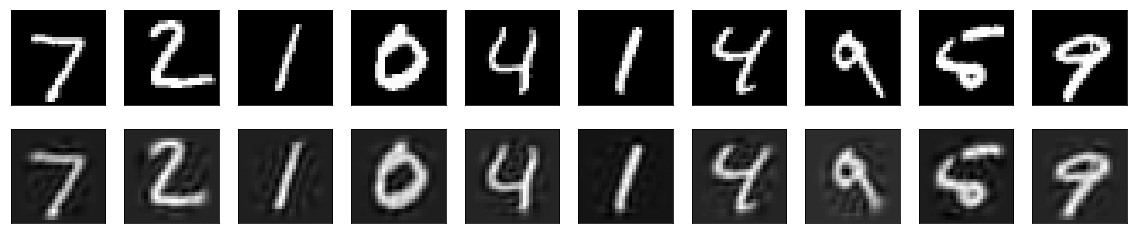

In [101]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))

fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(20,4))
for i in range(n):
    # display original
    ax = axes[0,i]
    ax.imshow(x_test[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = axes[1,i]
    ax.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [102]:
encoder_layer = autoencoder.get_layer(name="encoder")
encoder_weights = encoder_layer.get_weights()[0]
encoder_weights.shape

(784, 100)

In [103]:
pca_components = mnist_pca.components_
pca_components.shape

(100, 784)

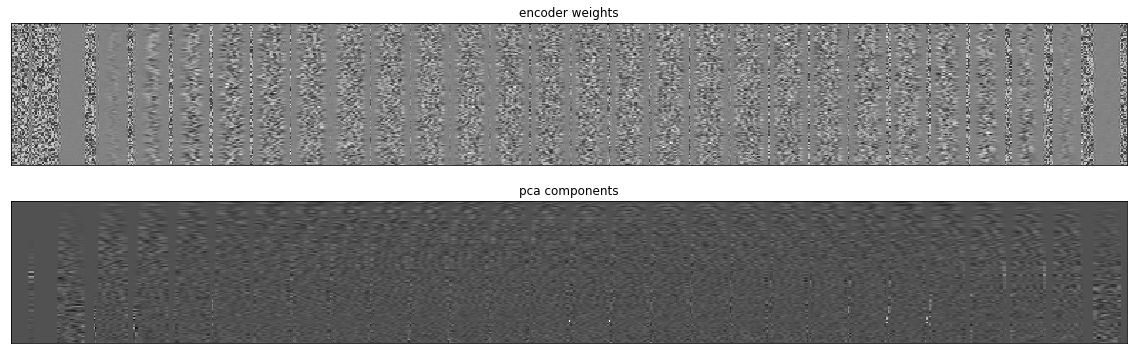

In [104]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,6))

axes[0].imshow(encoder_weights.T, cmap="gray")
axes[0].set_title("encoder weights")
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[1].imshow(pca_components, cmap="gray")
axes[1].set_title("pca components")
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)

<Figure size 1440x288 with 0 Axes>

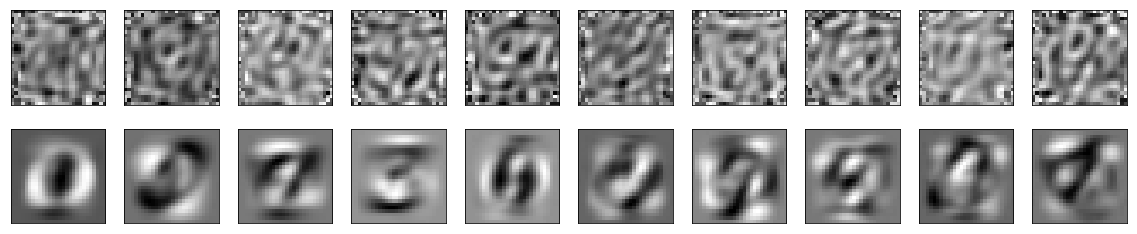

In [87]:
n = 10
plt.figure(figsize=(20, 4))

fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(20,4))
for i in range(n):
    # display original
    ax = axes[0,i]
    ax.imshow(encoder_weights.T[i,:].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = axes[1,i]
    ax.imshow(pca_components[i, :].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
input_img = keras.layers.Input(shape=(784,))
encoded = keras.layers.Dense(128, activation='relu')(input_img)
encoded = keras.layers.Dense(64, activation='relu')(encoded)
encoded = keras.layers.Dense(32, activation='relu')(encoded)

decoded = keras.layers.Dense(64, activation='relu')(encoded)
decoded = keras.layers.Dense(128, activation='relu')(decoded)
decoded = keras.layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')

In [11]:
autoencoder.fit(x_train, x_train, batch_size=256,
                epochs=100,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=callbacks
               )

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.2083 - val_loss: 0.1605
Epoch 2/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.1497 - val_loss: 0.1508
Epoch 3/100
60000/60000 [==============================] - 2s 28us/step - loss: 0.1351 - val_loss: 0.1266
Epoch 4/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.1263 - val_loss: 0.1219
Epoch 5/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.1200 - val_loss: 0.1126
Epoch 6/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.1152 - val_loss: 0.1120
Epoch 7/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.1117 - val_loss: 0.1110
Epoch 8/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.1088 - val_loss: 0.1082
Epoch 9/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.1065 - val_loss: 0.1

60000/60000 [==============================] - 2s 27us/step - loss: 0.0795 - val_loss: 0.0795
Epoch 71/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.0795 - val_loss: 0.0795

Epoch 00071: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 72/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.0795 - val_loss: 0.0795
Epoch 73/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.0795 - val_loss: 0.0795

Epoch 00073: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
Epoch 74/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.0795 - val_loss: 0.0795
Epoch 75/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.0795 - val_loss: 0.0795

Epoch 00075: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
Epoch 76/100
60000/60000 [==============================] - 2s 27us/step - loss: 0.0795 - val_loss: 0.0795
Epoch 77/100
60000/6

In [17]:
input_img = keras.layers.Input(
    shape=(28, 28,
           1))  # adapt this if using `channels_first` image data format

x = keras.layers.Conv2D(
    16, (3, 3), activation='elu', padding='same')(input_img)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = keras.layers.Conv2D(16, (3, 3), activation='elu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = keras.layers.Conv2D(16, (3, 3), activation='elu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = keras.layers.Conv2D(16, (3, 3), activation='elu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = keras.layers.Conv2D(32, (3, 3), activation='elu', padding='same')(x)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (1, 1, 32) i.e. 128-dimensional

x = keras.layers.Conv2DTranspose(
    32, (3, 3), strides=(2, 2), activation="elu", padding='valid')(encoded)
x = keras.layers.Conv2D(16, (3, 3), activation='elu', padding='same')(x)

x = keras.layers.Conv2DTranspose(
    16, (3, 3), strides=(2, 2), activation="elu", padding='valid')(x)
x = keras.layers.Conv2D(16, (3, 3), activation='elu', padding='same')(x)

x = keras.layers.Conv2DTranspose(
    16, (3, 3), strides=(2, 2), activation="elu", padding='same')(x)
x = keras.layers.Conv2D(16, (3, 3), activation='elu', padding='same')(x)

x = keras.layers.Conv2DTranspose(
    16, (3, 3), strides=(2, 2), activation="elu", padding='same')(x)
x = keras.layers.Conv2D(16, (3, 3), activation='elu', padding='same')(x)

decoded = keras.layers.Conv2D(
    1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.models.Model(input_img, decoded)

autoencoder.summary()

autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 16)        2320      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 16)          2320      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 16)          0         
__________

In [18]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [19]:
autoencoder.fit(x_train, x_train, batch_size=256,
                epochs=100,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=callbacks
               )

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 7s 111us/step - loss: 0.2418 - val_loss: 0.1770
Epoch 2/100
60000/60000 [==============================] - 6s 95us/step - loss: 0.1530 - val_loss: 0.1464
Epoch 3/100
60000/60000 [==============================] - 6s 93us/step - loss: 0.1314 - val_loss: 0.1283
Epoch 4/100
60000/60000 [==============================] - 6s 93us/step - loss: 0.1208 - val_loss: 0.1155
Epoch 5/100
60000/60000 [==============================] - 6s 92us/step - loss: 0.1136 - val_loss: 0.1116
Epoch 6/100
60000/60000 [==============================] - 5s 91us/step - loss: 0.1082 - val_loss: 0.1073
Epoch 7/100
60000/60000 [==============================] - 5s 91us/step - loss: 0.1047 - val_loss: 0.1013
Epoch 8/100
60000/60000 [==============================] - 5s 90us/step - loss: 0.1016 - val_loss: 0.0992
Epoch 9/100
60000/60000 [==============================] - 5s 90us/step - loss: 0.0990 - val_loss: 0.

60000/60000 [==============================] - 5s 91us/step - loss: 0.0768 - val_loss: 0.0763
Epoch 67/100
60000/60000 [==============================] - 5s 92us/step - loss: 0.0768 - val_loss: 0.0763

Epoch 00067: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.
Epoch 68/100
60000/60000 [==============================] - 5s 91us/step - loss: 0.0768 - val_loss: 0.0763
Epoch 69/100
60000/60000 [==============================] - 5s 91us/step - loss: 0.0768 - val_loss: 0.0763

Epoch 00069: ReduceLROnPlateau reducing learning rate to 1.525878978725359e-08.
Epoch 70/100
60000/60000 [==============================] - 5s 92us/step - loss: 0.0768 - val_loss: 0.0763
Epoch 71/100
60000/60000 [==============================] - 5s 91us/step - loss: 0.0768 - val_loss: 0.0763

Epoch 00071: ReduceLROnPlateau reducing learning rate to 1e-08.
Epoch 72/100
60000/60000 [==============================] - 5s 91us/step - loss: 0.0768 - val_loss: 0.0763
Epoch 73/100
60000/60000 [===========

KeyboardInterrupt: 

<Figure size 1440x288 with 0 Axes>

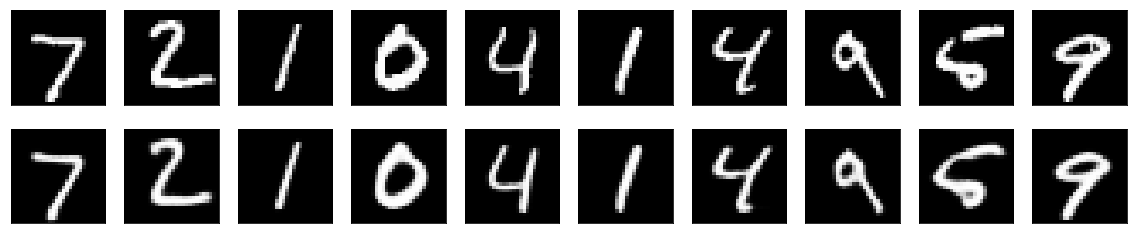

In [20]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))

fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(20,4))
for i in range(n):
    # display original
    ax = axes[0,i]
    ax.imshow(x_test[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = axes[1,i]
    ax.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [37]:
STD = .3

In [38]:
input_img = keras.layers.Input(
    shape=(28, 28,
           1))  # adapt this if using `channels_first` image data format

x = keras.layers.GaussianNoise(STD)(input_img)

x = keras.layers.Conv2D(
    16, (3, 3), activation='elu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = keras.layers.Conv2D(16, (3, 3), activation='elu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = keras.layers.Conv2D(16, (3, 3), activation='elu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = keras.layers.Conv2D(16, (3, 3), activation='elu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = keras.layers.Conv2D(32, (3, 3), activation='elu', padding='same')(x)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (1, 1, 32) i.e. 128-dimensional

x = keras.layers.Conv2DTranspose(
    32, (3, 3), strides=(2, 2), activation="elu", padding='valid')(encoded)
x = keras.layers.Conv2D(16, (3, 3), activation='elu', padding='same')(x)

x = keras.layers.Conv2DTranspose(
    16, (3, 3), strides=(2, 2), activation="elu", padding='valid')(x)
x = keras.layers.Conv2D(16, (3, 3), activation='elu', padding='same')(x)

x = keras.layers.Conv2DTranspose(
    16, (3, 3), strides=(2, 2), activation="elu", padding='same')(x)
x = keras.layers.Conv2D(16, (3, 3), activation='elu', padding='same')(x)

x = keras.layers.Conv2DTranspose(
    16, (3, 3), strides=(2, 2), activation="elu", padding='same')(x)
x = keras.layers.Conv2D(16, (3, 3), activation='elu', padding='same')(x)

decoded = keras.layers.Conv2D(
    1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.models.Model(input_img, decoded)

autoencoder.summary()

autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
gaussian_noise_4 (GaussianNo (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 14, 14, 16)        2320      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 7, 7, 16)          2320      
__________

In [39]:
x_test_noise = x_test + np.random.normal(scale=STD, size=x_test.shape)

In [40]:
autoencoder.fit(x_train, x_train, batch_size=256,
                epochs=100,
                shuffle=True,
                validation_data=(x_test_noise, x_test),
                callbacks=callbacks
               )

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 7s 117us/step - loss: 0.2377 - val_loss: 0.1751
Epoch 2/100
60000/60000 [==============================] - 6s 98us/step - loss: 0.1597 - val_loss: 0.1469
Epoch 3/100
60000/60000 [==============================] - 6s 97us/step - loss: 0.1398 - val_loss: 0.1400
Epoch 4/100
60000/60000 [==============================] - 6s 96us/step - loss: 0.1294 - val_loss: 0.1223
Epoch 5/100
60000/60000 [==============================] - 6s 95us/step - loss: 0.1225 - val_loss: 0.1223
Epoch 6/100
60000/60000 [==============================] - 6s 95us/step - loss: 0.1176 - val_loss: 0.1140
Epoch 7/100
60000/60000 [==============================] - 6s 95us/step - loss: 0.1142 - val_loss: 0.1148
Epoch 8/100
60000/60000 [==============================] - 6s 95us/step - loss: 0.1112 - val_loss: 0.1118
Epoch 9/100
60000/60000 [==============================] - 6s 95us/step - loss: 0.1088 - val_loss: 0.

<Figure size 1440x288 with 0 Axes>

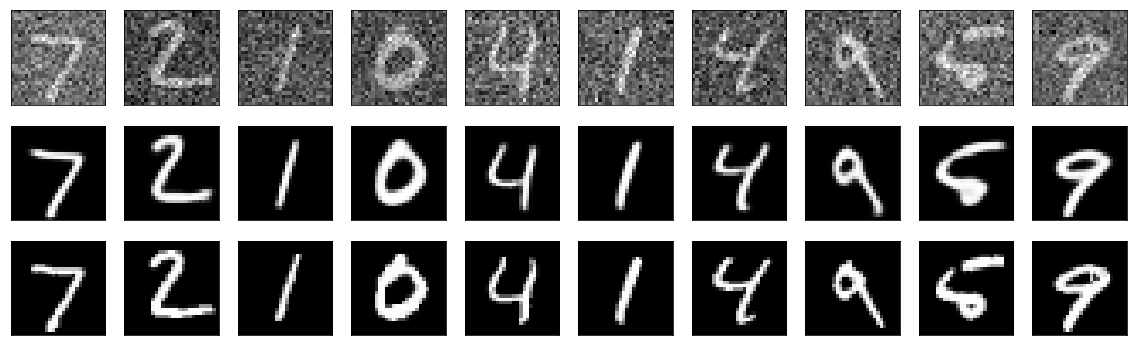

In [41]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))

fig, axes = plt.subplots(nrows=3, ncols=n, figsize=(20,6))
for i in range(n):
    # display input
    ax = axes[0,i]
    ax.imshow(x_test_noise[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = axes[1,i]
    ax.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original
    ax = axes[2,i]
    ax.imshow(x_test[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [42]:
(x_train, _), (x_test, _) = keras.datasets.cifar100.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train.shape

(50000, 32, 32, 3)

In [44]:
np.std(x_train, axis=(1,2,3)).mean()

0.21646152

In [65]:
STD = .1

x_test_noise = x_test + np.random.normal(scale=STD, size=x_test.shape)

In [60]:
input_img = keras.layers.Input(
    shape=(32, 32,
           3))  # adapt this if using `channels_first` image data format

x = keras.layers.GaussianNoise(STD)(input_img)

x = keras.layers.Conv2D(
    16, (3, 3), activation='elu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(16, (3, 3), activation='elu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = keras.layers.Conv2D(32, (3, 3), activation='elu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = keras.layers.Conv2D(64, (3, 3), activation='elu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

x = keras.layers.Conv2D(128, (3, 3), activation='elu', padding='same')(x)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (1, 1, 32) i.e. 128-dimensional

x = keras.layers.Conv2DTranspose(
    128, (3, 3), strides=(2, 2), activation="elu", padding='same')(encoded)
x = keras.layers.Conv2D(128, (3, 3), activation='elu', padding='same')(x)

x = keras.layers.Conv2DTranspose(
    64, (3, 3), strides=(2, 2), activation="elu", padding='same')(x)
x = keras.layers.Conv2D(64, (3, 3), activation='elu', padding='same')(x)

x = keras.layers.Conv2DTranspose(
    32, (3, 3), strides=(2, 2), activation="elu", padding='same')(x)
x = keras.layers.Conv2D(32, (3, 3), activation='elu', padding='same')(x)

x = keras.layers.Conv2DTranspose(
    16, (3, 3), strides=(2, 2), activation="elu", padding='same')(x)
x = keras.layers.Conv2D(16, (3, 3), activation='elu', padding='same')(x)

x = keras.layers.Conv2DTranspose(
    16, (3, 3), strides=(2, 2), activation="elu", padding='same')(x)
x = keras.layers.Conv2D(16, (3, 3), activation='elu', padding='same')(x)

x = keras.layers.BatchNormalization()(x)

decoded = keras.layers.Conv2D(
    3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.models.Model(input_img, decoded)

autoencoder.summary()

autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train, batch_size=256,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noise, x_test),
                callbacks=callbacks
               )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
gaussian_noise_12 (GaussianN (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_134 (Conv2D)          (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 8, 8, 16)          0         
__________

In [69]:
import keras.backend as K

In [81]:
input_img = keras.layers.Input(
    shape=(32, 32,
           3))  # adapt this if using `channels_first` image data format

x = keras.layers.GaussianNoise(STD)(input_img)

enc_32 = keras.layers.Conv2D(
    64, (3, 3), activation='elu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(enc_32)
x = keras.layers.BatchNormalization()(x)

enc_16 = keras.layers.Conv2D(64, (3, 3), activation='elu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(enc_16)

enc_8 = keras.layers.Conv2D(64, (3, 3), activation='elu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(enc_8)

enc_4 = keras.layers.Conv2D(64, (3, 3), activation='elu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(enc_4)

enc_2 = keras.layers.Conv2D(256, (3, 3), activation='elu', padding='same')(x)
# encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (1, 1, 32) i.e. 128-dimensional

# x = keras.layers.Conv2DTranspose(
#     128, (3, 3), strides=(2, 2), activation="elu", padding='same')(encoded)
# x = keras.layers.SeparableConv2D(128, (3, 3), activation='elu', padding='same')(x)

dec_4 = keras.layers.Conv2DTranspose(
    64, (3, 3), strides=(2, 2), activation="elu", padding='same')(enc_2)
comb_4 = keras.layers.Concatenate(axis=3)( [dec_4,enc_4] )
x = keras.layers.Conv2D(128, (3, 3), activation='elu', padding='same')(comb_4)

dec_8 = keras.layers.Conv2DTranspose(
    64, (3, 3), strides=(2, 2), activation="elu", padding='same')(x)
comb_8 = keras.layers.Concatenate(axis=3)( [dec_8,enc_8] )
x = keras.layers.Conv2D(128, (3, 3), activation='elu', padding='same')(comb_8)

dec_16 = keras.layers.Conv2DTranspose(
    64, (3, 3), strides=(2, 2), activation="elu", padding='same')(x)
comb_16 = keras.layers.Concatenate(axis=3)( [dec_16,enc_16] )
x = keras.layers.Conv2D(128, (3, 3), activation='elu', padding='same')(comb_16)

dec_32 = keras.layers.Conv2DTranspose(
    64, (3, 3), strides=(2, 2), activation="elu", padding='same')(x)
comb_32 = keras.layers.Concatenate(axis=3)( [dec_32,enc_32] )
x = keras.layers.Conv2D(64, (3, 3), activation='elu', padding='same')(comb_32)

x = keras.layers.BatchNormalization()(x)

decoded = keras.layers.Conv2D(
    3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.models.Model(input_img, decoded)

autoencoder.summary(line_length=100)

autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train, batch_size=256,
                epochs=100,
                shuffle=True,
                validation_data=(x_test_noise, x_test),
                callbacks=callbacks
               )

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_35 (InputLayer)            (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
gaussian_noise_30 (GaussianNoise (None, 32, 32, 3)     0           input_35[0][0]                   
____________________________________________________________________________________________________
conv2d_242 (Conv2D)              (None, 32, 32, 64)    1792        gaussian_noise_30[0][0]          
____________________________________________________________________________________________________
max_pooling2d_141 (MaxPooling2D) (None, 16, 16, 64)    0           conv2d_242[0][0]                 
___________________________________________________________________________________________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 1440x288 with 0 Axes>

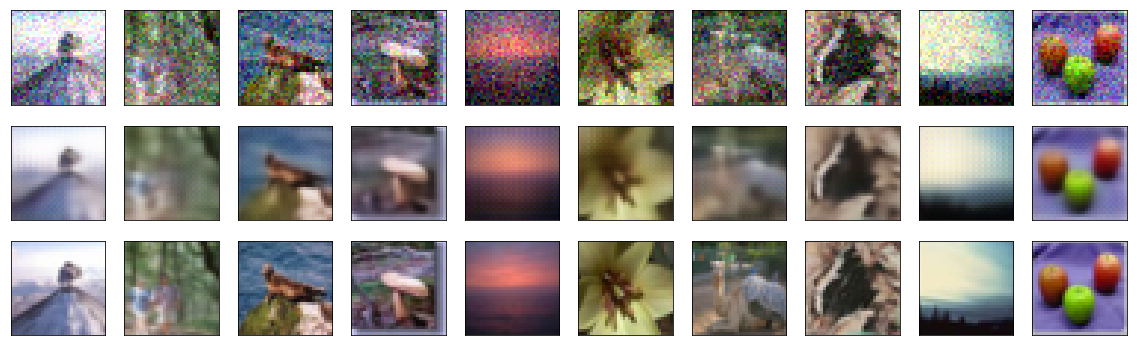

In [82]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))

fig, axes = plt.subplots(nrows=3, ncols=n, figsize=(20,6))
for i in range(n):
    # display input
    ax = axes[0,i]
    ax.imshow(x_test_noise[i].reshape(32, 32,3), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = axes[1,i]
    ax.imshow(decoded_imgs[i].reshape(32, 32,3), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original
    ax = axes[2,i]
    ax.imshow(x_test[i].reshape(32, 32,3), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()